- Function to process Mice
- Function to perform AE
- Function to perform Kmeans SMOTE
- Function to perform all the EDA
  - Isolation forest
  - Z score
  - Non linear relationships
- Function to perform PCA

    The above all comes under the main function

    
- Function to give out Plots and other EDA after the PCA is done. It gets the PCA dataset as the input

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
import os

import shap
import lime
from lime import lime_tabular

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SVMSMOTE, ADASYN

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from sklearn.cluster import KMeans

import missingno as msno

from fancyimpute import IterativeImputer as MICE
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam 


from sklearn.cluster import DBSCAN
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from collections import Counter

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import KMeansSMOTE
from sklearn.mixture import GaussianMixture


from xgboost import XGBClassifier
from rgf.sklearn import RGFClassifier  # Regularized Greedy Forest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from joblib import dump, load
import logging

import time


In [10]:
def preprocess_dataframe(df):

    start_time = time.time()  # Start timing

    # Replace LABEL values
    df["LABEL"] = df["LABEL"].replace({0: "Normal", 1: "Distressed"})
    df["ID"] = df["ID"].replace({0: "changed"})
    
    # Select columns from A36 to LABEL
    selected_columns = df.loc[:, 'A36':'LABEL']
    
    # Drop columns not in the selected range
    df_selected = df.drop(columns=df.columns.difference(selected_columns.columns))
    df_label = df_selected.copy()
    
    # Count the number of zeros in each row
    zeros_count = (df_label == 0).sum(axis=1)
    
    # Filter out rows with different zero thresholds
    filtered_df2L = df_label[zeros_count <= 2]
    filtered_df3L = df_label[zeros_count <= 3]
    filtered_df4L = df_label[zeros_count <= 4]
    filtered_df5L = df_label[zeros_count <= 5]
    filtered_df8L = df_label[zeros_count <= 8]
    filtered_df10L = df_label[zeros_count <= 10]
    
    # Replace 0 with NaN values in all filtered dataframes
    filtered_df2 = filtered_df2L.replace(0, np.nan)
    filtered_df3 = filtered_df3L.replace(0, np.nan)
    filtered_df4 = filtered_df4L.replace(0, np.nan)
    filtered_df5 = filtered_df5L.replace(0, np.nan)
    filtered_df8 = filtered_df8L.replace(0, np.nan)
    filtered_df10 = filtered_df10L.replace(0, np.nan)
    
    # Print info of the final dataframe with the strictest zero threshold
    # filtered_df2.drop("LABEL", axis=1).info()

    print(filtered_df2.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for preprocess_dataframe: {elapsed_time:.2f} mins")
    
    return {
        "filtered_df2": filtered_df2,
        "filtered_df3": filtered_df3,
        "filtered_df4": filtered_df4,
        "filtered_df5": filtered_df5,
        "filtered_df8": filtered_df8,
        "filtered_df10": filtered_df10,
        "filtered_df2L": filtered_df2L,
        "filtered_df3L": filtered_df3L,
        "filtered_df4L": filtered_df4L,
        "filtered_df5L": filtered_df5L,
        "filtered_df8L": filtered_df8L,
        "filtered_df10L": filtered_df10L
    }


def impute_with_mice(df, dfL):

    start_time = time.time()  # Start timing

    df = df.drop("LABEL", axis=1)
    
    # Create the MICE imputer object
    imputer = IterativeImputer(max_iter=10, random_state=0)
    
    # Fit the imputer to the data and transform it
    df_mice = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Display the first few rows of the imputed DataFrame
    print("Dataframe before MICE imputation: \n", df.head(3))
    print("DataFrame after MICE imputation:\n", df_mice.head(3))
    
    # Saving the labels back in the dataframe
    labels = dfL["LABEL"]
    print("Length of labels: ", len(labels))
    
    # Reassigning the values in LABEL column
    df_mice["LABEL"] = labels.values
    
    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60

    print(f"Time taken for impute_with_mice: {elapsed_time:.2f} mins")


    return df_mice


def impute_with_autoencoder(df, dfL):

    start_time = time.time()  # Start timing

    # To further process the numerical columns
    df = df.drop("LABEL", axis=1)
    
    
    # Fill the nan with 0 for autoencoder training
    df_replaced = df.replace(np.nan, 0)

    # Normalize data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_replaced)
    
    # Split data into train and validation sets
    X_train, X_val = train_test_split(df_scaled, test_size=0.2, random_state=42)
    
    # Define the autoencoder architecture
    input_dim = X_train.shape[1]
    encoding_dim = int(input_dim / 2)
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer='l2')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Print model summary
    autoencoder.summary()
    
    # Train the autoencoder
    history = autoencoder.fit(X_train, X_train,
                              epochs=35,
                              batch_size=32,
                              shuffle=True,
                              validation_data=(X_val, X_val))
    
    # Predict using the original df_scaled (with zeros)
    data_imputed_scaled = autoencoder.predict(df_scaled)
    
    # Inverse transform to get data_imputed_df
    data_imputed = scaler.inverse_transform(data_imputed_scaled)
    data_imputed_df = pd.DataFrame(data_imputed, columns=df.columns, index=df.index)
    
    # Saving a copy version
    df_AEimputed = df.copy()
    
    # Replace only the missing values with imputed values
    for col in df.columns:
        mask = df[col].isnull()
        df_AEimputed.loc[mask, col] = data_imputed_df.loc[mask, col]
    
    print("Original Data with Missing Values:\n", df.isnull().sum())
    print("Data after Autoencoder Imputation:\n", df_AEimputed.isnull().sum())
    
    # Reassign values of LABEL column back to the dataset
    df_AEimputed["LABEL"] = dfL["LABEL"].values

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for impute_with_autoencoder: {elapsed_time:.2f} mins")
    
    return df_AEimputed


def reprocess_for_smote_pca(df_imputed):

    start_time = time.time()  # Start timing

    """
    Reprocess the imputed dataframe for SMOTE and PCA by replacing string values in the "LABEL" column with binary values.
    
    Parameters:
    df_imputed (pd.DataFrame): The imputed dataframe with "LABEL" column containing string values.
    
    Returns:
    pd.DataFrame: The reprocessed dataframe with binary values in the "LABEL" column.
    """
    df_reprocessed = df_imputed.copy()
    df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for reprocess_for_smote_pca: {elapsed_time:.2f} mins")
    
    return df_reprocessed



def svmsmote_resampling(df):
    start_time = time.time()  # Start timing

    # Preprocessing
    X = df.drop(columns=["LABEL"])
    y = df["LABEL"]

    # Separate the classes
    X_minority = X[y == 1]
    X_majority = X[y == 0]

    # Visualize the minority class
    plt.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Minority Class Distribution")
    plt.legend()
    plt.show()

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply SVMSMOTE
    svmsmote = SVMSMOTE(random_state=42)
    X_resampled, y_resampled = svmsmote.fit_resample(X_scaled, y)

    # Verify the balance of the new dataset
    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))

    # Convert X_resampled back to original scale
    X_resampled = scaler.inverse_transform(X_resampled)

    # Convert X_resampled and y_resampled to DataFrames
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled_df = pd.DataFrame(y_resampled, columns=['LABEL'])

    # Concatenate X_resampled_df and y_resampled_df along columns axis
    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

    # Save resampled DataFrame to Excel (uncomment if needed)
    # resampled_df.to_excel('df_autoencoder_SVMSMOTE.xlsx', index=False)

    df_processed = resampled_df.copy()

    # Visualize the resampled dataset
    plt.scatter(X_resampled[y_resampled == 0][:, 0], X_resampled[y_resampled == 0][:, 1], label='Majority Class', alpha=0.6)
    plt.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1], label='Minority Class', alpha=0.6)
    plt.title("Resampled Dataset Distribution")
    plt.legend()
    plt.show()

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for svmsmote_resampling: {elapsed_time:.2f} mins")

    return df_processed



def process_pca(df):

    start_time = time.time()  # Start timing

    def compute_pca(df, columns, n_components=2):
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df[columns])
        
        # Compute PCA
        pca = PCA(n_components=n_components)
        pca_data = pca.fit_transform(scaled_data)
        
        # Create a DataFrame with the PCA results
        pca_columns = [f'PC{i+1}' for i in range(n_components)]
        pca_df = pd.DataFrame(pca_data, columns=pca_columns)
        
        return pca_df

    def pca_transformed_df(df, ratio_categories, n_components=2):
        pca_results = []

        for category, columns in ratio_categories.items():
            pca_df = compute_pca(df, columns, n_components)
            pca_df = pca_df.add_prefix(f'{category}_')
            pca_results.append(pca_df)

        combined_pca_df = pd.concat(pca_results, axis=1)
        return combined_pca_df

    # Define your ratio categories and their respective columns
    ratio_categories = {
        "Liquidity_and_Coverage_Ratios" :  ['A36', 'A37', 'A38', 'A44', 'A41', 'A43'],
        "Leverage_Ratios" : ['A39', 'A40', 'A42', 'A48', 'A71', 'A72', 'A73'],
        "Activity_Ratios" :  ['A45', 'A46', 'A47', 'A50','A53', 'A54', 'A56'],
        "Profitability_Ratios" :  ['A49', 'A57', 'A58', 'A59', 'A61', 'A62'],
        "Cost_and_Expense_Ratios" :  ['A63', 'A64', 'A65', 'A66'],
        "Cash_Flow_Ratios" : ['A67', 'A68', 'A69', 'A70'],
        "Growth_Ratios" : ['A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81'],
        "Per_Share_Ratios" :  ['A82', 'A83', 'A84']
    }

    # Compute PCA and get the combined DataFrame
    combined_pca_df = pca_transformed_df(df, ratio_categories, n_components=2)

    # Add the LABEL column back to the combined PCA DataFrame
    combined_pca_df["LABEL"] = df["LABEL"]

    # Save the combined PCA DataFrame to a CSV file (optional)
    # combined_pca_df.to_csv('combined_pca_ratios.csv', index=False)

    # Display the first few rows of the combined PCA DataFrame
    print(combined_pca_df.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for process_pca: {elapsed_time:.2f} mins")

    return combined_pca_df


def main(df):
        
        print("Executing the main function.")
        datasets = preprocess_dataframe(df)

        print("Preprocessed Datasets.")

        print("_______________________________________________________________________________")
        print("*******************************************************************************")
        print("                        Proceedings for MICE:")
        print("_______________________________________________________________________________")
        print("*******************************************************************************")

        start_time = time.time()  # Start timing

        # Impute null values using MICES
        mice_imputed_df = impute_with_mice(datasets["filtered_df2"], datasets["filtered_df2L"])
        
        # Reprocess the data for SMOTE and PCA
        df_mice_reprocessed = reprocess_for_smote_pca(mice_imputed_df)
        
        # Apply SMOTE resampling
        df_mice_resampled = svmsmote_resampling(df_mice_reprocessed)
        
        # Process PCA
        pca_df_mice = process_pca(df_mice_resampled)

        end_time = time.time()  # End timing
        elapsed_time = (end_time - start_time) / 60
        
        print("_______________________________________________________________________________")
        print(f" Total time taken: {elapsed_time:.2f} mins")

        print(" ")
        print(" ")
        print(" ")
        
        print("_______________________________________________________________________________")
        print("*******************************************************************************")
        print("                        Proceedings for Autoencoder:")
        print("_______________________________________________________________________________")
        print("*******************************************************************************")

        start_time = time.time()  # Start timing

        # Impute null values using Autoencoders
        ae_imputed_df = impute_with_autoencoder(datasets["filtered_df3"], datasets["filtered_df3L"])

        # Reprocess the data for SMOTE and PCA
        df_autoencoder_reprocessed = reprocess_for_smote_pca(ae_imputed_df)

        # Apply SMOTE resampling
        df_autoencoder_resampled = svmsmote_resampling(df_autoencoder_reprocessed)

        # Process PCA
        pca_df_autoencoder = process_pca(df_autoencoder_resampled)

        end_time = time.time()  # End timing
        elapsed_time = (end_time - start_time) / 60
        
        print("_______________________________________________________________________________")
        print(f" Total time taken: {elapsed_time:.2f} mins")

        pca_df_mice.to_excel("SVMSMOTE_MICE_3_PCA.xlsx")
        pca_df_autoencoder.to_excel("SVMSMOTE_AE_3_PCA.xlsx")


In [11]:
df = pd.read_excel("C:\\Users\\dev\\Desktop\\financial distress\\financial_distress_python.xlsx")

Executing the main function.
         A36       A37       A38       A39       A40       A41       A42  \
80  2.523392  2.523302  1.014784  1.595410  0.286062  0.920518  2.495750   
81  3.615532  3.615399  1.436531  0.036077  0.265880  0.948497  2.761092   
82  2.285354  2.285278  0.364360 -0.357243  0.272066  0.922328  2.675580   

         A43       A44       A45  ...       A76       A77       A78       A79  \
80  0.400940  3.495750  0.015180  ...  0.017401  6.198123  6.858067 -2.986409   
81  0.362409  3.761092  0.018626  ... -0.019641 -0.786114 -0.768645 -0.964392   
82  0.373985  3.675580  0.019985  ...  0.007605  8.771772  9.772075 -1.335116   

         A80       A81       A82       A83       A84   LABEL  
80 -6.802062 -1.236756  0.002919 -0.021170 -0.013083  Normal  
81 -0.403760 -3.244087  0.000742 -0.019156 -0.005283  Normal  
82 -0.519225 -0.166025  0.003555 -0.023129 -0.013871  Normal  

[3 rows x 46 columns]
Time taken for preprocess_dataframe: 0.00 mins
Preprocessed Datase

C:\Users\dev\AppData\Local\Temp\ipykernel_28908\907001843.py:171: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


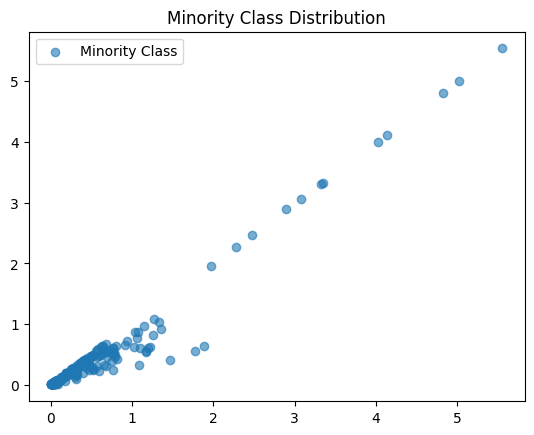

Original class distribution: Counter({0: 10062, 1: 267})
Resampled class distribution: Counter({0: 10062, 1: 10062})


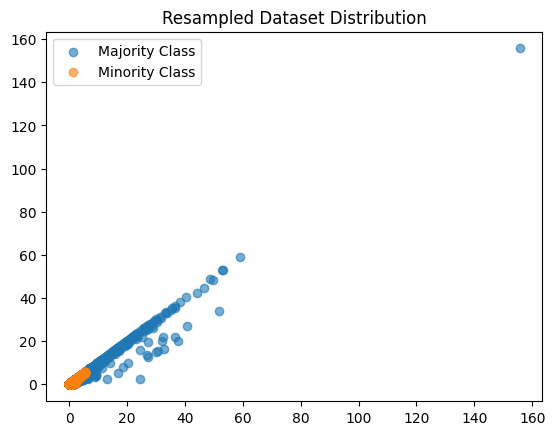

Time taken for svmsmote_resampling: 0.02 mins
   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           1.042056                           0.002180   
1                           1.632578                           0.001952   
2                           0.793909                           0.001994   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.720010             0.011030            -0.076553   
1            -0.769846             0.012027            -0.071856   
2            -0.751851             0.002886            -0.072096   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0            -1.016892                  0.124673                 -0.160409   
1            -1.007540                  0.080382                 -0.188388   
2            -1.003800                  0.079384                 -0.161531   

   Cost_and_Expense_Ratios_PC1  Cost_and_Expense_Ratios_PC2  \
0   

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 22)             │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 45)             │         1,035 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,047 (8.00 KB)

 Trainable params: 2,047 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.1132 - val_loss: 0.9393
Epoch 2/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 1.4414 - val_loss: 0.8176
Epoch 3/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.9021 - val_loss: 0.7335
Epoch 4/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.6818 - val_loss: 0.6838
Epoch 5/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.8938 - val_loss: 0.6492
Epoch 6/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.7147 - val_loss: 0.6270
Epoch 7/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 0.5599 - val_loss: 0.6100
Epoch 8/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.4971 - val_loss: 0.5981
Epoch 9/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.3883 - val_loss: 0.5857
Epoch 10/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.4571 - val_loss: 0.5803
Epoch 11/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 0.4436 - val_loss: 0.5728
Epoch 12/35
351/351 ━━━━━━━━━━━━

C:\Users\dev\AppData\Local\Temp\ipykernel_28908\907001843.py:171: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


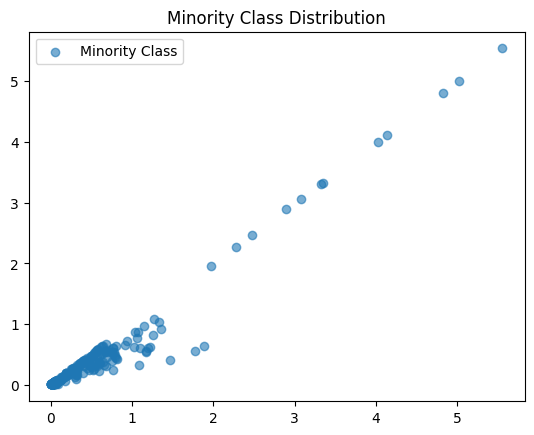

Original class distribution: Counter({0: 13708, 1: 307})
Resampled class distribution: Counter({0: 13708, 1: 13708})


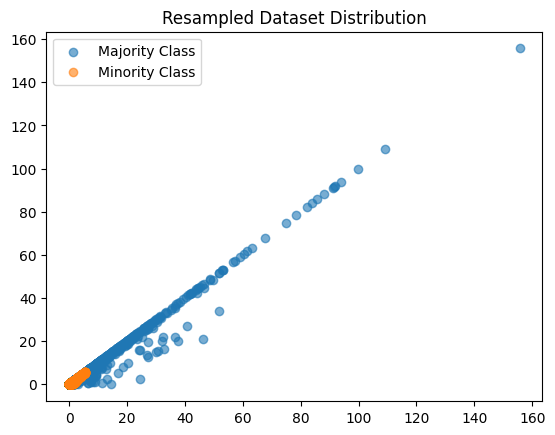

Time taken for svmsmote_resampling: 0.02 mins
   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           0.920817                           0.476882   
1                           1.423701                           0.400266   
2                           0.679692                           0.560519   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.698925             0.017120            -0.931793   
1            -0.750452             0.016862            -0.925343   
2            -0.732379             0.015110            -0.923487   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0            -0.119453                 -0.007166                 -0.010029   
1            -0.104647                 -0.009425                 -0.008557   
2            -0.094147                 -0.007476                 -0.008542   

   Cost_and_Expense_Ratios_PC1  Cost_and_Expense_Ratios_PC2  \
0   

In [12]:
main(df)